<a href="https://colab.research.google.com/github/Varshithatangeti/FMML_2023_ASSIGNMENTS/blob/main/FMML_Module_9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-09 13:32:24--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.172.170.43, 18.172.170.106, 18.172.170.8, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.172.170.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   186MB/s    in 0.2s    

2024-05-09 13:32:24 (186 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


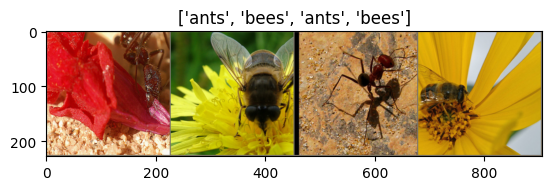

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 86.5MB/s]


In [9]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.5878 Acc: 0.6885

Epoch 1/4
----------
Loss: 0.3706 Acc: 0.8484

Epoch 2/4
----------
Loss: 0.5069 Acc: 0.7746

Epoch 3/4
----------
Loss: 0.6055 Acc: 0.7500

Epoch 4/4
----------
Loss: 0.5993 Acc: 0.7787



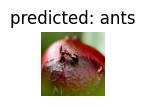

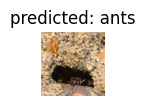

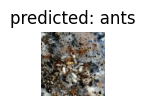

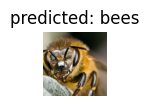

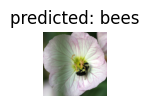

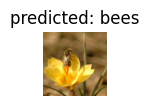

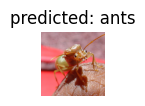

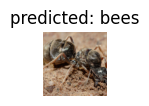

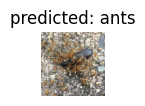

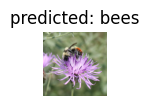

In [10]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


#Question 1
Data augmentations like resizing, cropping, rotating, flipping, and adding noise are essential techniques in machine learning, especially for tasks like image classification or object detection. Their significance lies in several key areas:

1. **Increasing Dataset Size:** By applying augmentations, you effectively increase the size of your training dataset. This is crucial because larger datasets often lead to better generalization and performance of machine learning models.

2. **Regularization:** Augmentations act as a form of regularization, helping prevent overfitting by exposing the model to variations of the input data. This encourages the model to learn more robust and generalized features rather than memorizing specific training examples.

3. **Improved Generalization:** Augmentations simulate real-world variability in the data, making the model more resilient to variations it might encounter during inference on unseen data. For example, resizing and cropping simulate different viewpoints or zoom levels, while flipping and rotating mimic changes in orientation.

4. **Data Diversity:** Augmentations help in capturing a diverse range of data patterns and characteristics. This is particularly important in scenarios where the training data may not fully represent the variability present in the real-world data the model will encounter.

5. **Reducing Bias:** Augmentations can help reduce biases that may be present in the original dataset. For instance, if the training data predominantly contains images of certain orientations or sizes, augmentations can balance this bias by generating variations that represent other orientations or sizes.

6. **Efficient Training:** Augmentations can also help in efficient training by reducing the need for collecting and annotating a vast amount of diverse training data manually. Instead, you can generate diverse training samples from a smaller set of annotated data.

Overall, using data augmentations as part of the training process is a fundamental strategy for improving the robustness, generalization, and performance of machine learning models, particularly in tasks involving image and sequence data.



#QUESTION 2
If you train a ResNet model from scratch without using pretraining (i.e., setting `pretrained=False`), several factors can affect its performance:

1. **Training Time:** Training a deep neural network like ResNet from scratch can be computationally expensive and time-consuming compared to using a pretrained model. It may require a larger number of epochs and more data to achieve comparable performance.

2. **Data Requirements:** Training a deep model from scratch effectively requires a substantial amount of labeled training data to learn meaningful representations. Without pretrained weights, the model starts with random initialization, and learning useful features without sufficient data can be challenging.

3. **Generalization:** Pretrained models, especially those trained on large, diverse datasets like ImageNet, have learned generic features that often generalize well to other tasks. Training from scratch may lead to overfitting on the training data if not enough regularization techniques are applied.

4. **Performance:** The performance of a ResNet model trained from scratch can vary depending on factors such as dataset size, complexity of the task, model architecture, hyperparameters, and regularization techniques. In general, it may achieve lower performance compared to using a pretrained model, especially if the dataset is not large enough or lacks diversity.

5. **Fine-tuning:** Even if you train a ResNet model from scratch initially, it's common to use transfer learning later by fine-tuning the model on a smaller dataset related to your specific task. Fine-tuning allows leveraging the pretrained knowledge while adapting the model to the new task, potentially improving performance significantly.

Overall, while training a ResNet model from scratch can be done, it often requires substantial computational resources, careful hyperparameter tuning, and a large and diverse dataset to achieve competitive performance compared to using a pretrained model as a starting point.


#QUESTION 3
Using a pretrained ResNet model on a dataset significantly different from the task at hand, such as using a model pretrained on ImageNet for the ants vs. bees classification task, can still yield good performance. There are several reasons for this:

1. **Transfer Learning:** Pretrained models capture generic features and patterns that are transferable across different tasks and datasets. While ImageNet contains a wide variety of objects and scenes, many of the learned features (e.g., edges, textures, shapes) can be relevant for tasks like image classification, including ants vs. bees.

2. **Feature Extraction:** Pretrained models act as feature extractors in transfer learning. Lower layers of the network learn low-level features like edges and textures, which are often similar across different datasets. Higher layers learn more abstract and task-specific features, which can adapt to the new task during fine-tuning.

3. **Regularization:** Using a pretrained model provides implicit regularization, preventing overfitting especially when the target dataset is small. The pretrained weights act as a form of prior knowledge that guides the model towards learning more generalized representations.

4. **Speed of Convergence:** Transfer learning with a pretrained model typically leads to faster convergence during training compared to training from scratch. This is because the model starts with weights that are already somewhat aligned with the new task, reducing the number of epochs required for training.

5. **Data Augmentation:** Augmenting the target dataset with techniques like resizing, cropping, and flipping further enhances the compatibility between the pretrained model and the new task. These augmentations introduce variations that help the model generalize better.

While using a pretrained model can provide a strong starting point, it's important to note that fine-tuning on the target dataset is often necessary to achieve optimal performance. Fine-tuning involves adjusting the pretrained weights to better suit the specific characteristics of the new dataset, potentially improving accuracy and reducing any domain gap between the pretrained data and the target data.